## Reliability Engineering for Airplane Turbofan Engines
* <b> Student Name: </b> Bryce Kastner
* <b> Student ID: </b> 862255672

An application on the PHM08 data set provided by NASA

## 1. Import useful packages and data

In [232]:
import warnings
warnings. simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression, BayesianRidge
from statsmodels.stats.outliers_influence import variance_inflation_factor
import arviz as az
import bambi as bmb
import pymc3 as pm
from pymc3 import HalfCauchy, Model, Normal, glm, plot_posterior_predictive_glm, sample


In [233]:
# converting data from txt file to useable data frame need to categorize
# the data rows/columns appropriately 
index_col_names = ['unit_num','time_cycle']
oper_set_col_names = ['oper_set{}'.format(i) for i in range(1,4)]
sensor_col_names = ['sm_{}'.format(i) for i in range(1,22)]
all_col = index_col_names + oper_set_col_names + sensor_col_names
print(all_col)

# Shows a vector with the names of the columns we wish to extract from the 
# txt file

['unit_num', 'time_cycle', 'oper_set1', 'oper_set2', 'oper_set3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']


In [234]:
# Load training dataset into working enviornment.
train_df = pd.read_csv('../Capstone/Challenge_Data/CMaps/train_FD001.txt',
                      delim_whitespace = True, names = all_col)
train_df
 


,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [235]:
# RUL for training purposes.
RUL_train = pd.read_csv('../Capstone/Challenge_Data/CMaps/RUL_FD001.txt',
                      delim_whitespace = True, names = ['RUL'])
RUL_train['unit_num'] = RUL_train.index+1
RUL_train

# Now we have our RUL values for the 100 turbofan engines in the database

,RUL,unit_num
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [236]:
# same classification for testing dataframe
test_df = pd.read_csv('../Capstone/Challenge_Data/CMaps/test_FD001.txt',
                      delim_whitespace = True, names = all_col)
test_df.head()

,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [237]:
# inital look at data. Quick EDA
train_df.describe()

,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [238]:
# no missing values so imputation is OBE.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_num    20631 non-null  int64  
 1   time_cycle  20631 non-null  int64  
 2   oper_set1   20631 non-null  float64
 3   oper_set2   20631 non-null  float64
 4   oper_set3   20631 non-null  float64
 5   sm_1        20631 non-null  float64
 6   sm_2        20631 non-null  float64
 7   sm_3        20631 non-null  float64
 8   sm_4        20631 non-null  float64
 9   sm_5        20631 non-null  float64
 10  sm_6        20631 non-null  float64
 11  sm_7        20631 non-null  float64
 12  sm_8        20631 non-null  float64
 13  sm_9        20631 non-null  float64
 14  sm_10       20631 non-null  float64
 15  sm_11       20631 non-null  float64
 16  sm_12       20631 non-null  float64
 17  sm_13       20631 non-null  float64
 18  sm_14       20631 non-null  float64
 19  sm_15       20631 non-nul

In [239]:
train_df[train_df.unit_num == 1]
# Selecting to see one Turbofan unit we can see the life of the item

# Unit 1's life expires on time cycle 192

,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295


## 2. Computing/concatenating RUL variable into our training and testing df for supervised learning analysis

Now that our datasets are loaded and we have a genreal understanding of the structure. We must determine remaining useful life given each time cycle. I will do this by calculating the max life cycle for each unique engine and then subract the max life span by the time cycle phase to get an estiamted parameter of RUL.

In [240]:
# group data by unit number and filter based off of time cycle.

# Max time cycle for each unit num.
max_time_cycle = train_df.groupby('unit_num')['time_cycle'].max()
max_time_cycle # printed to ensure grouping was correct

RULe = pd.DataFrame(max_time_cycle).reset_index()
RULe.columns = ['unit_num', 'max_tc']
RULe

# Shows max time cycle for 100 turbofan engines

,unit_num,max_tc
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [241]:
# now I need to combine my new variable to the training dataframe
train_df = train_df.merge(RULe, on = ['unit_num'],how = 'left')
train_df['RUL'] = train_df['max_tc'] - train_df['time_cycle']
train_df

,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,max_tc,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,200,1


In [242]:
# now that we have our RUL variable we can drop our computation row
train_df.drop('max_tc', axis = 1, inplace = True)

# View RUL for first turbofan unit by time_cycle
train_df[train_df.unit_num == 1].iloc[:,[1,-1]]

,time_cycle,RUL
0,1,191
1,2,190
2,3,189
3,4,188
4,5,187
...,...,...
187,188,4
188,189,3
189,190,2
190,191,1


In [243]:
# for our testing dataframe to add in the RUL column we will need to
# reverse engineer our prior eqautions idea.

test_df['RUL'] = 0
for i in range (1,101):
    test_df.loc[test_df.unit_num == i, 'RUL'] = range(int(RUL_train.RUL[RUL_train.unit_num==i])+
                                                      len(test_df[test_df.unit_num==i])-1,
         int(RUL_train.RUL[RUL_train.unit_num==i])-1,-1)
    
test_df.iloc[:,[0,1,-1]]    
    

,unit_num,time_cycle,RUL
0,1,1,142
1,1,2,141
2,1,3,140
3,1,4,139
4,1,5,138
...,...,...,...
13091,100,194,24
13092,100,195,23
13093,100,196,22
13094,100,197,21


In [244]:
# Backcheck calculation to actuals.
RUL_train

,RUL,unit_num
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [245]:
test_df.loc[test_df.unit_num == 2,['unit_num', 'time_cycle', 'RUL']].tail()

# RUL input match for unit 2 = 98

,unit_num,time_cycle,RUL
75,2,45,102
76,2,46,101
77,2,47,100
78,2,48,99
79,2,49,98


## 3. Feature Selection and Data Visualization 

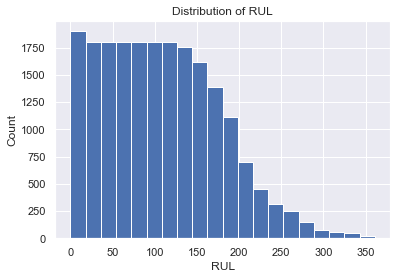

In [246]:
# Histogram of RUL
plt.hist(train_df['RUL'], bins = 20)
plt.xlabel('RUL')
plt.ylabel('Count')
plt.title('Distribution of RUL')
plt.show()

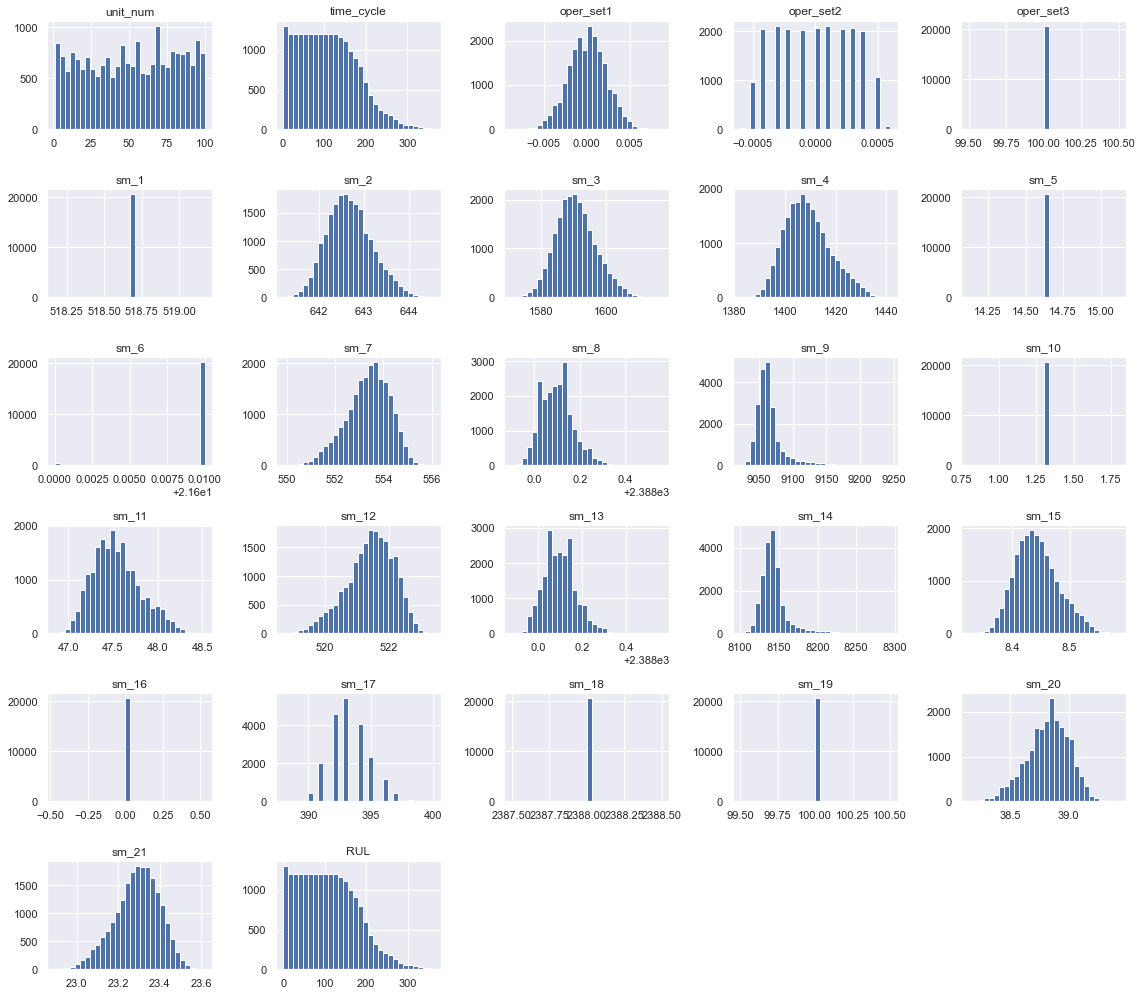

In [247]:
# This graph gives us a look at the distribution of our various parameters
sns.set(font_scale = 1)
train_df.hist(bins =30, figsize=(16,14))
plt.tight_layout()
plt.show();

# Can point out a few variables that remain constant.
# likely have very little info to add in a predictive model.

In [248]:
def create_correlation_matrix(df, figsize=(16,14)):
    corr = df.corr(method = 'pearson')
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr,
               linewidths=.5,
               vmin=-1, vmax=1, center=0,
               cmap=sns.diverging_palette(20,220,n=200),
               square=True,
               ax=ax)
    plt.title("Correlation Matrix", fontsize=10)

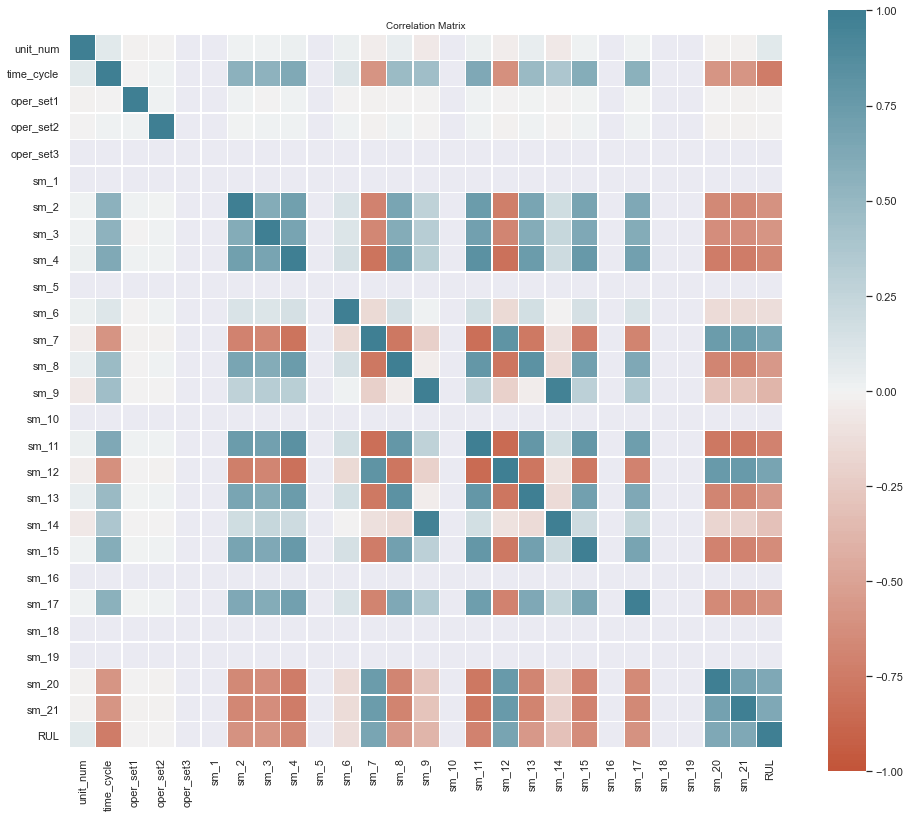

In [249]:
create_correlation_matrix(train_df);

# grey cells indicate no correlation or NA value.
# will view numerically to confirm

In [250]:
train_df.corr()
# My intuition is correct and NAN values 
# can remove NAN variables from analysis

,unit_num,time_cycle,oper_set1,oper_set2,oper_set3,sm_1,sm_2,sm_3,sm_4,sm_5,...,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21,RUL
unit_num,1.000000,0.078753,-0.017895,-0.006197,NaN,NaN,0.014133,0.012621,0.026116,NaN,...,0.044230,-0.059473,0.022486,NaN,0.013513,NaN,NaN,-0.020589,-0.016465,0.078753
time_cycle,0.078753,1.000000,-0.004527,0.016132,NaN,NaN,0.549898,0.543947,0.624577,NaN,...,0.477523,0.370324,0.588676,NaN,0.566995,NaN,NaN,-0.583597,-0.585923,-0.736241
oper_set1,-0.017895,-0.004527,1.000000,0.011660,NaN,NaN,0.009030,-0.005651,0.009544,NaN,...,0.002318,-0.004469,0.007652,NaN,0.002599,NaN,NaN,-0.005713,-0.014559,-0.003198
oper_set2,-0.006197,0.016132,0.011660,1.000000,NaN,NaN,0.007266,0.009068,0.014673,NaN,...,0.018156,-0.006310,0.014156,NaN,0.012280,NaN,NaN,-0.010554,-0.007846,-0.001948
oper_set3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sm_2,0.014133,0.549898,0.009030,0.007266,NaN,NaN,1.000000,0.602610,0.714949,NaN,...,0.661792,0.179752,0.675975,NaN,0.629886,NaN,NaN,-0.661841,-0.668050,-0.606484
sm_3,0.012621,0.543947,-0.005651,0.009068,NaN,NaN,0.602610,1.000000,0.678413,NaN,...,0.600963,0.237137,0.639921,NaN,0.600017,NaN,NaN,-0.625941,-0.633901,-0.584520
sm_4,0.026116,0.624577,0.009544,0.014673,NaN,NaN,0.714949,0.678413,1.000000,NaN,...,0.745158,0.190748,0.758459,NaN,0.703499,NaN,NaN,-0.748067,-0.745193,-0.678948
sm_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [251]:
# Drop all variables that produce NANs entirely
cols_drop = ['oper_set3','sm_1','sm_5','sm_10','sm_16','sm_18','sm_19']
train_df = train_df.drop(cols_drop, axis = 1)
test_df = test_df.drop(cols_drop, axis = 1)

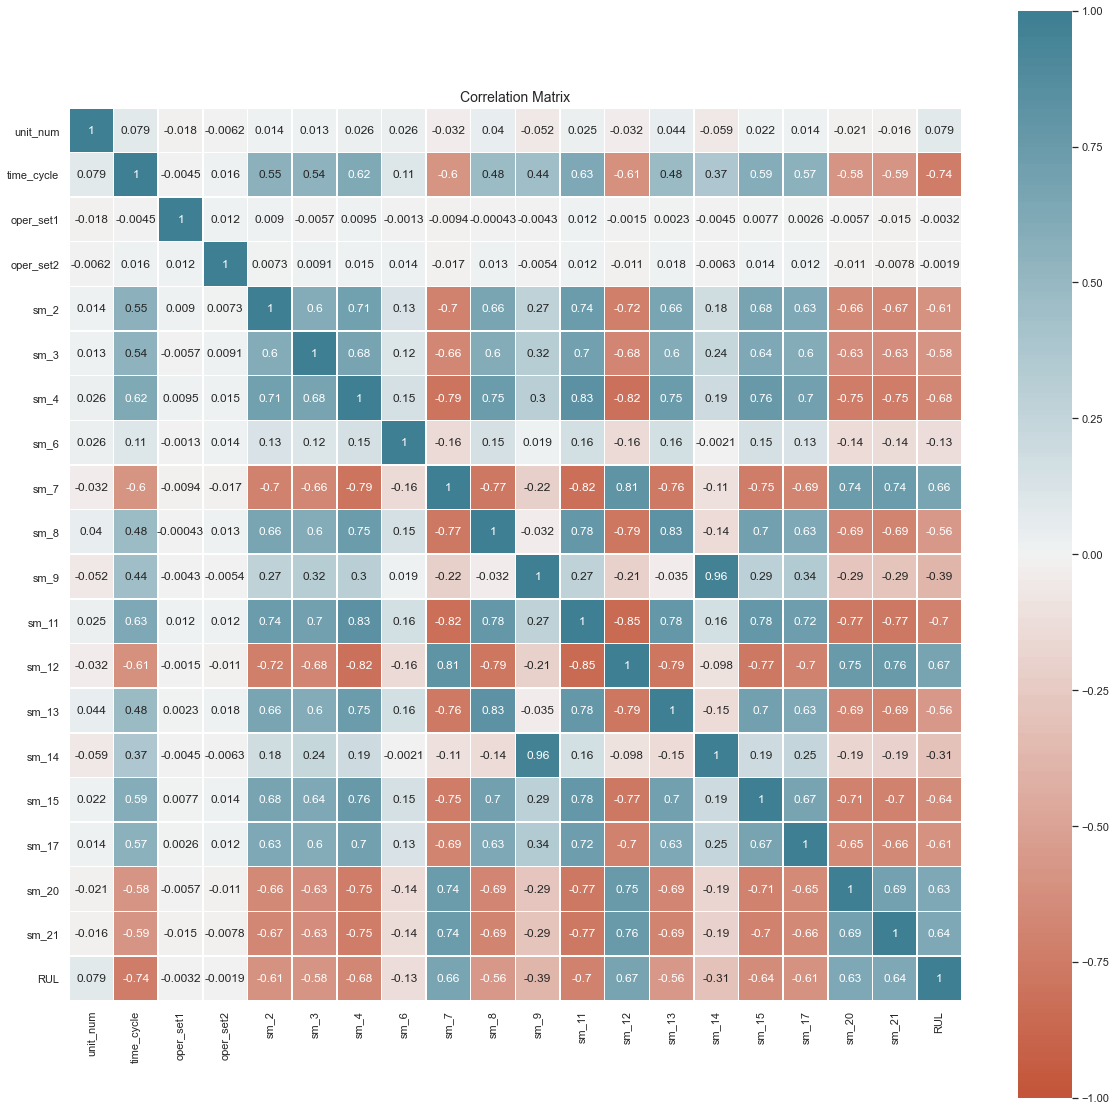

In [252]:
# Second look at Correlation Matrix removing NANs
# redefined to show numeric value in windows
def create_correlation_matrix2(df, figsize=(20,20)):
    corr = df.corr(method = 'pearson')
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr,
               linewidths=.5,
               vmin=-1, vmax=1, center=0,
               cmap=sns.diverging_palette(20,220,n=200),
               square=True,
               ax=ax,
               annot=True)
    plt.title("Correlation Matrix", fontsize=14)
    
create_correlation_matrix2(train_df);

In [253]:
train_df.corr()['RUL']

# having now knowing what correlates to our desired variable
# we can move forward with model creation.

unit_num      0.078753
time_cycle   -0.736241
oper_set1    -0.003198
oper_set2    -0.001948
sm_2         -0.606484
sm_3         -0.584520
sm_4         -0.678948
sm_6         -0.128348
sm_7          0.657223
sm_8         -0.563968
sm_9         -0.390102
sm_11        -0.696228
sm_12         0.671983
sm_13        -0.562569
sm_14        -0.306769
sm_15        -0.642667
sm_17        -0.606154
sm_20         0.629428
sm_21         0.635662
RUL           1.000000
Name: RUL, dtype: float64

In [254]:
# Most correlated variables
most_corr = train_df.corr().abs()['RUL'].sort_values(ascending=False)
most_corr

# will look to use the 4 most correlated variables so long as VIF 
# maintains an appropriate level

RUL           1.000000
time_cycle    0.736241
sm_11         0.696228
sm_4          0.678948
sm_12         0.671983
sm_7          0.657223
sm_15         0.642667
sm_21         0.635662
sm_20         0.629428
sm_2          0.606484
sm_17         0.606154
sm_3          0.584520
sm_8          0.563968
sm_13         0.562569
sm_9          0.390102
sm_14         0.306769
sm_6          0.128348
unit_num      0.078753
oper_set1     0.003198
oper_set2     0.001948
Name: RUL, dtype: float64

## 4. Variable Normalization

Now that we have identified some features that can be used as statistically significant predictor variables we should normalize the data set to avoid dependencies that can been seen by differing unit measurements.

In [255]:
# list of features we would like to normalize
features = list(train_df.columns[1:-1])
features

# apply min max scaler to perform normalization. values between -1,1
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
train_df[features] = min_max_scaler.fit_transform(train_df[features])
test_df[features] = min_max_scaler.fit_transform(test_df[features])
train_df.head()
test_df.head()


,unit_num,time_cycle,oper_set1,oper_set2,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_14,sm_15,sm_17,sm_20,sm_21,RUL
0,1,-1.000000,0.3125,0.384615,0.192429,-0.156063,-0.435573,1.0,0.217742,-0.268293,-0.607050,-0.452055,0.068493,-0.348837,-0.695481,-0.305849,-0.25,0.000000,0.240198,142
1,1,-0.993377,-0.3125,-0.538462,-0.634069,0.008050,-0.549520,1.0,0.600806,-0.414634,-0.541916,-0.041096,0.269406,-0.209302,-0.444186,-0.544583,0.00,0.290909,0.291437,141
2,1,-0.986755,0.0625,0.076923,-0.160883,-0.070371,-0.307739,1.0,0.302419,-0.219512,-0.502989,-0.041096,0.182648,-0.348837,-0.614217,0.067114,0.00,0.400000,0.362208,140
3,1,-0.980132,0.5500,-0.076923,-0.173502,-0.216827,-0.100265,1.0,0.286290,-0.317073,-0.681839,-0.342466,-0.086758,-0.255814,-0.564208,-0.435283,-0.50,0.254545,0.240764,139
4,1,-0.973510,0.2000,-0.076923,-0.129338,-0.057388,-0.284051,1.0,0.322581,-0.414634,-0.693180,-0.301370,0.264840,-0.348837,-0.624219,-0.325983,-0.75,0.236364,0.352017,138


## 5. Predictive Model

In [256]:
# split explanitory from predictor variables
X = train_df[['time_cycle','sm_11','sm_4']]
y = train_df[['RUL']]
X_test = test_df[['time_cycle','sm_11','sm_4']]
y_test = test_df[['RUL']]


In [257]:
data = X.join(y)
f_col = data.pop('RUL')
data.insert(0, 'RUL', f_col)
data

n = 2000
data = data.iloc[:n]
data

,RUL,time_cycle,sm_11,sm_4
0,191,-1.000000,-0.261905,-0.380486
1,190,-0.994460,-0.238095,-0.294733
2,189,-0.988920,-0.500000,-0.258947
3,188,-0.983380,-0.666667,-0.337610
4,187,-0.977839,-0.488095,-0.190749
...,...,...,...,...
1995,140,-0.551247,-0.380952,-0.500675
1996,139,-0.545706,-0.523810,-0.189061
1997,138,-0.540166,-0.583333,-0.482107
1998,137,-0.534626,-0.738095,-0.679608


In [258]:
# Metrcis for baselineing 
def eval_preds(predictions, true_val):
    mae = metrics.mean_absolute_error(predictions, true_val)
    rmse = np.sqrt(metrics.mean_squared_error(predictions, true_val))

    return mae, rmse

In [259]:
# Naive Baseline Model - want to create a model that does better than simply
# assuming the mean value performs best

mean_pred = y['RUL'].mean()
mean_preds = [mean_pred for _ in range(len(y_test))]

# naive model performance. model baseline = mb
mb_mae, mb_rmse = eval_preds(mean_preds, y_test['RUL'])
print('Mean Baseline MAE: {:.4f}'.format(mb_mae))
print('Mean Baseline MSE: {:.4f}'.format(mb_rmse))

Mean Baseline MAE: 54.1275
Mean Baseline MSE: 67.7938


In [260]:
# MULTICOLLINARITY CHECK
# Will check for independence via the VIF.

vif = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
pd.DataFrame(list(zip(X.columns,vif)))

# VIF > 10 indicated heavy multicollinearity, if >10 then should be removed, <5 is preferable

,0,1
0,time_cycle,2.175763
1,sm_11,4.433254
2,sm_4,3.410421


In [261]:
# Formula for OLS regression
OLS = LinearRegression()
OLS.fit(X,y)

pred = OLS.predict(X_test)

# OLS model eval
ols_mae, ols_rmse = eval_preds(pred, y_test['RUL'].values)
print('OLS model MAE: {:.4f}'.format(ols_mae))
print('OLS model RMSE: {:.4f}'.format(ols_rmse))

OLS model MAE: 36.3906
OLS model RMSE: 49.7510


In [272]:
OLS.coef_

array([[-83.68829684, -54.96196337, -40.51933102]])

In [273]:
OLS.intercept_

array([60.34949686])

In [262]:
print('The OLS regressor is {:0.2f}% better than the baseline.'.format((100*abs(ols_mae - mb_mae))/mb_mae))

The OLS regressor is 32.77% better than the baseline.


#### Formula for OLS equation for Bayesian approach

In [263]:
# Formula for OLS regression
BR = BayesianRidge()
BR.fit(X,y['RUL'])

pred2 = BR.predict(X_test)

# OLS model eval
B_mae, B_rmse = eval_preds(pred2, y_test['RUL'].values)
print('OLS model MAE: {:.4f}'.format(B_mae))
print('OLS model RMSE: {:.4f}'.format(B_rmse))

# with a sufficently large amount of data Bayesian method converges to the frequentist method

# producing the same error output

OLS model MAE: 36.3906
OLS model RMSE: 49.7510


In [264]:
BR.coef_

array([-83.6771736 , -54.95354089, -40.52601364])

In [265]:
BR.intercept_

60.35480633265196

In [266]:
print('Variance score: %.2f' % metrics.r2_score(y_test['RUL'].values, pred2))

Variance score: 0.29


## PYMC3 for model interpretation 

In [267]:
model = bmb.Model("RUL ~ time_cycle + sm_11 + sm_4", data)
trace = model.fit(draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/beccaweldon/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/beccaweldon/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/beccaweldon/opt/anaconda3/lib/python3.8/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [RUL_sigma, sm_4, sm_11, time_cycle, Intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3451 seconds.


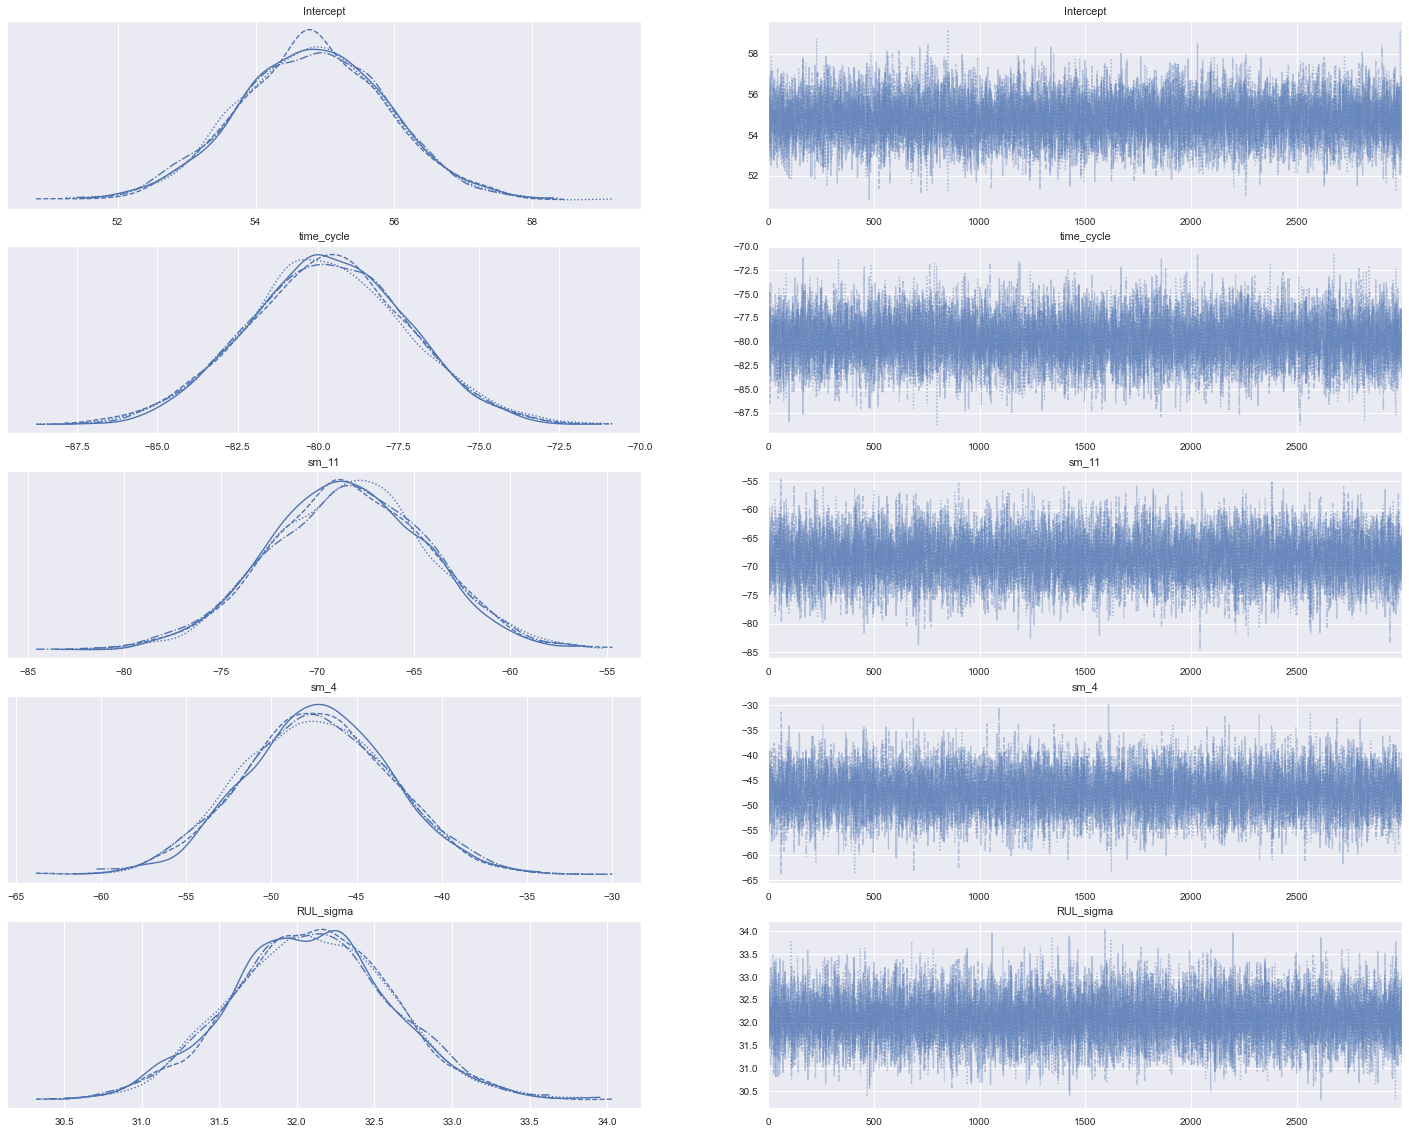

In [268]:
az.plot_trace(trace, figsize=(25, 20));

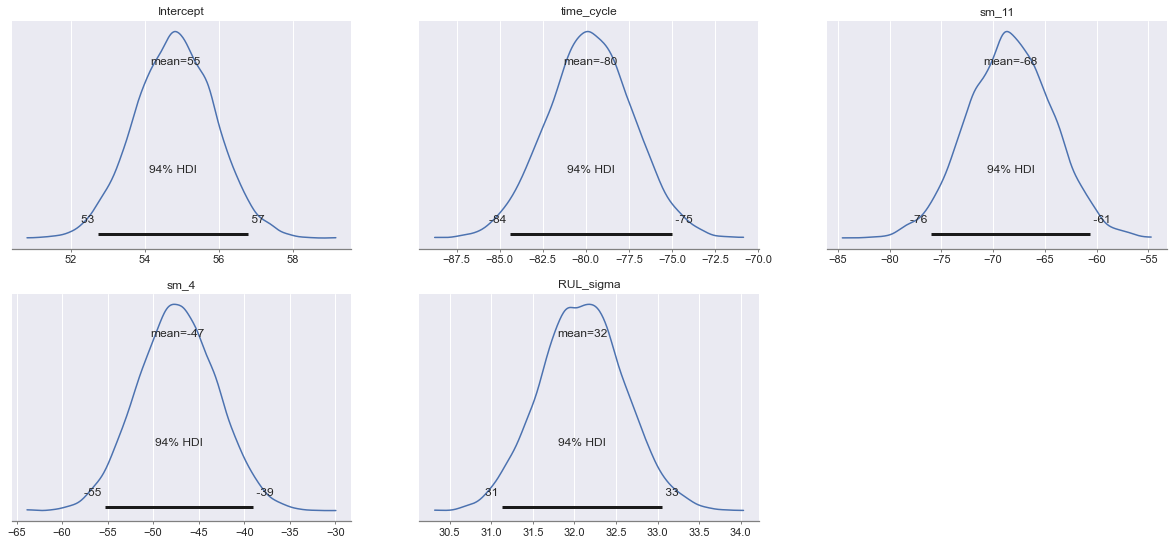

In [269]:
pm.plot_posterior(trace);

In [270]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,54.820,1.077,52.741,56.783,0.009,0.007,13494.0,10225.0,1.0
time_cycle,-79.744,2.499,-84.406,-74.983,0.022,0.015,13497.0,8586.0,1.0
sm_11,-68.365,4.113,-76.015,-60.605,0.042,0.029,9809.0,8197.0,1.0
sm_4,-47.335,4.373,-55.309,-38.996,0.043,0.031,10138.0,8142.0,1.0
RUL_sigma,32.093,0.512,31.124,33.050,0.004,0.003,14598.0,8228.0,1.0


<ipython-input-271-1bebb47b26ac>:1: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(trace);


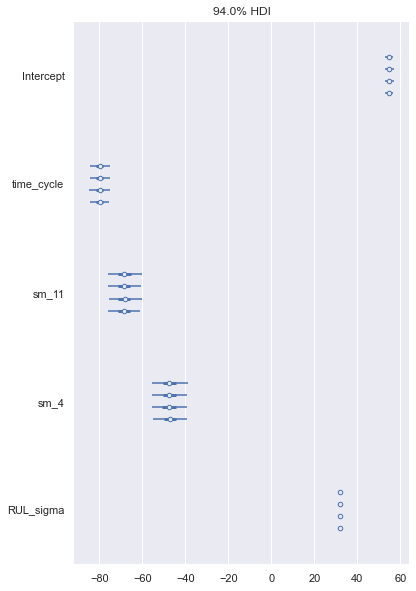

In [271]:
pm.forestplot(trace);